**Recommendation System Using Autoencoders**

## Initial Setups

In [ ]:
#Required libraries
import numpy as np                    #for numerical computation
import pandas as pd                   #for data manipulation and analysis
import matplotlib.pyplot as plt       #for data visualization

## Business Understanding

Academic Paper:

Ferreira, D., Silva, S., Abelha, A., & Machado, J. (2020). Recommendation system using autoencoders. Applied Sciences, 10(16), 5510.

Objectives of Recommendation Systems:

- Increase the number of sales
- Improve company’s revenue
- Encourage engagement and activity on products and services
- Gain competitive advantage
- Calibrate user preferences
- Make personalized recommendations


Recommendation System at Target:

https://www.forbes.com/sites/kashmirhill/2012/02/16/how-target-figured-out-a-teen-girl-was-pregnant-before-her-father-did/?sh=1e21f4ab6668


## Import the Dataset

MovieLens dataset:

https://grouplens.org/datasets/movielens/

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path_movies = '/content/drive/MyDrive/Recommendation System/ml-25m/movies.dat'
path_users = '/content/drive/MyDrive/Recommendation System/ml-25m/users.dat'
path_ratings = '/content/drive/MyDrive/Recommendation System/ml-25m/ratings.dat'

In [ ]:
data_behaviors = pd.read_csv(path_behaviors, sep='\t', header=None, names=columns_behaviors)


In [ ]:
#Read dataset from files
# --> Check README file

movies  = pd.read_csv(path_movies,'movies.dat', sep='\t', header = None, engine = 'python', encoding = 'latin-1')
users   = pd.read_csv(path_users,'users.dat', sep='\t', header = None, engine = 'python', encoding = 'latin-1')
ratings = pd.read_csv(path_ratings,'ratings.dat', sep='\t', header = None, engine = 'python', encoding = 'latin-1')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only
  exec(code_obj, self.user_global_ns, self.user_ns)


TypeError: ignored

In [ ]:
movies.head()

,0,1,2
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [ ]:
#MovieID::Title::Genres
movies.rename(columns = {0 : 'movie_id', 1 : 'title', 2 : 'genres'}, inplace = True)

In [ ]:
movies.head()

,movie_id,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [ ]:
movies.shape

(3883, 3)

In [ ]:
#UserID::Gender::Age::Occupation::Zip-code
users.rename(columns = {0 : 'user_id', 1 : 'gender', 2 : 'age', 3 : 'occupation', 4 : 'zipcode'},
             inplace = True)
users.head()

,user_id,gender,age,occupation,zipcode
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


In [ ]:
users.shape

(6040, 5)

In [ ]:
#UserID::MovieID::Rating::Timestamp
ratings.rename(columns = {0 : 'user_id', 1 : 'movie_id', 2 : 'rating', 3 : 'timestamp'},
               inplace = True)

ratings.head()

,user_id,movie_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [ ]:
#A Unix timestamp is the number of seconds between a particular date and January 1, 1970 at UTC.
from datetime import datetime
datetime.fromtimestamp(ratings['timestamp'][0])

datetime.datetime(2001, 1, 1, 1, 42, 40)

In [ ]:
ratings.shape

(1000209, 4)

In [ ]:
np.unique(ratings['user_id']).shape[0]

6040

In [ ]:
np.unique(ratings['movie_id']).shape[0]

3706

In [ ]:
print(np.max(ratings['movie_id']))
print(np.max(movies['movie_id']))

3952
3952


In [ ]:
#Check duplicates
np.sum(ratings.duplicated(subset = ['user_id', 'movie_id'], keep = False))

0

## Data Prepration

In [ ]:
#Scale ratings
ratings['scaled_rating'] = ((ratings['rating'] - ratings['rating'].min()) + 0.5) / (ratings['rating'].max() - ratings['rating'].min() + 0.5)

In [ ]:
ratings.head()

,user_id,movie_id,rating,timestamp,scaled_rating
0,1,1193,5,978300760,1.000000
1,1,661,3,978302109,0.555556
2,1,914,3,978301968,0.555556
3,1,3408,4,978300275,0.777778
4,1,2355,5,978824291,1.000000


In [ ]:
ratings['scaled_rating'].value_counts()

0.777778    348971
0.555556    261197
1.000000    226310
0.333333    107557
0.111111     56174
Name: scaled_rating, dtype: int64

In [ ]:
data = np.zeros((users.shape[0], max(ratings['movie_id'])))

In [ ]:
data.shape

(6040, 3952)

In [ ]:
for user_id in users['user_id']:
    movie_id = ratings.loc[ratings['user_id'] == user_id, 'movie_id']
    user_rating = ratings.loc[ratings['user_id'] == user_id, 'scaled_rating']
    data[user_id - 1, movie_id - 1] = user_rating

In [ ]:
#Measure sparsity of data
np.sum(data == 0) / (data.shape[0] * data.shape[1]) * 100

95.8097794393651

In [ ]:
#Find users with less than 20 reviews
np.sum(np.sum(data > 0, axis = 1) < 20)

0

In [ ]:
#Find items with less than 20 reviews
np.sum(np.sum(data > 0, axis = 0) < 20)

909

In [ ]:
rm_movies_indx = np.where(np.sum(data > 0, axis = 0) < 20)
rm_movies_indx

(array([  32,   36,   50,   52,   55,   58,   66,   74,   89,   90,   95,
          97,  105,  107,  108,  113,  114,  118,  119,  123,  126,  127,
         128,  129,  130,  132,  133,  135,  136,  137,  138,  141,  142,
         145,  166,  177,  188,  191,  196,  199,  211,  220,  225,  227,
         242,  243,  244,  250,  263,  282,  283,  284,  285,  309,  310,
         322,  335,  358,  374,  384,  393,  394,  395,  396,  397,  398,
         399,  400,  401,  402,  403,  405,  410,  438,  502,  525,  529,
         544,  556,  558,  559,  560,  562,  565,  566,  571,  575,  577,
         578,  581,  583,  590,  597,  600,  603,  606,  613,  616,  617,
         619,  621,  622,  623,  624,  625,  628,  629,  631,  633,  635,
         637,  640,  641,  642,  643,  645,  648,  650,  651,  653,  654,
         656,  657,  659,  663,  665,  671,  674,  675,  676,  678,  680,
         681,  682,  683,  685,  686,  688,  689,  692,  695,  697,  698,
         700,  702,  705,  711,  712, 

In [ ]:
#Remove items with less than 20 reviews
data = np.delete(data, rm_movies_indx[0], axis = 1)

In [ ]:
data.shape

(6040, 3043)

In [ ]:
movies_indx = np.delete(np.arange(0, np.max(movies['movie_id'])), rm_movies_indx[0])
movies_indx.shape

(3043,)

In [ ]:
#Devide dataset into train and test
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(data, test_size = 0.3, random_state = 123)

In [ ]:
X_train.shape

(4228, 3043)

In [ ]:
X_test.shape

(1812, 3043)

## Biuld Deep Learning Model

### Base Model 

In [ ]:
#Import Keras
from tensorflow import keras

In [ ]:
#Define the Model Architecture
#Encoder
model_b_encoder = keras.models.Sequential()
weight_initializer = keras.initializers.HeNormal()
model_b_encoder.add(keras.layers.Dense(256, 
                                       input_dim = int(X_train.shape[1]), 
                                       activation = "tanh", 
                                       kernel_initializer = weight_initializer))

#Decoder
model_b_decoder = keras.models.Sequential()
model_b_decoder.add(keras.layers.Dense(int(X_train.shape[1]),
                                       input_dim = 256,
                                       activation = "sigmoid", 
                                       kernel_initializer = weight_initializer))

#Auto-encoder
model_b_ae = keras.models.Sequential([model_b_encoder, model_b_decoder])
model_b_ae.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 256)               779264    
_________________________________________________________________
sequential_1 (Sequential)    (None, 3043)              782051    
Total params: 1,561,315
Trainable params: 1,561,315
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#Configure the model
opt = keras.optimizers.Adam(learning_rate = 0.001) #learning rate
model_b_ae.compile(optimizer = opt, loss = 'mean_squared_error')

In [ ]:
#Train the model
history_b = model_b_ae.fit(X_train, X_train, epochs = 50, batch_size = 16, validation_split = 0.2)

Epoch 1/50
212/212 [==============================] - 4s 16ms/step - loss: 0.0741 - val_loss: 0.0249
Epoch 2/50
212/212 [==============================] - 2s 11ms/step - loss: 0.0234 - val_loss: 0.0225
Epoch 3/50
212/212 [==============================] - 2s 12ms/step - loss: 0.0215 - val_loss: 0.0207
Epoch 4/50
212/212 [==============================] - 3s 12ms/step - loss: 0.0198 - val_loss: 0.0195
Epoch 5/50
212/212 [==============================] - 2s 11ms/step - loss: 0.0194 - val_loss: 0.0186
Epoch 6/50
212/212 [==============================] - 3s 12ms/step - loss: 0.0176 - val_loss: 0.0179
Epoch 7/50
212/212 [==============================] - 2s 12ms/step - loss: 0.0175 - val_loss: 0.0173
Epoch 8/50
212/212 [==============================] - 2s 11ms/step - loss: 0.0160 - val_loss: 0.0169
Epoch 9/50
212/212 [==============================] - 3s 12ms/step - loss: 0.0148 - val_loss: 0.0165
Epoch 10/50
212/212 [==============================] - 3s 13ms/step - loss: 0.0146 - val_lo

Text(0.5, 1.0, 'Loss - Epochs: Base Model')

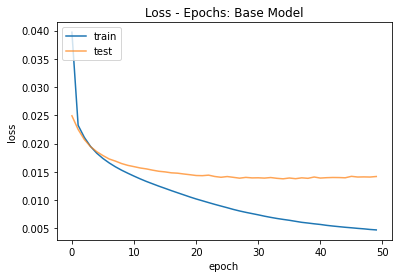

In [ ]:
#Loss - Epochs
plt.figure(figsize = (6, 4))
plt.plot(history_b.history['loss'], label = 'train')
plt.plot(history_b.history['val_loss'], alpha = 0.7, label = 'test')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc = 'upper left')
plt.title('Loss - Epochs: Base Model')

In [ ]:
#Prediction on test dataset
X_train_hat = model_b_ae.predict(X_train)

In [ ]:
#Items w/ a rating greater than 4 can be considered as relevant and the rest as irrelevant
#4: 0.78, 5: 1
ratings['scaled_rating'].value_counts()

0.777778    348971
0.555556    261197
1.000000    226310
0.333333    107557
0.111111     56174
Name: scaled_rating, dtype: int64

In [ ]:
X_train_binary = np.where(X_train >= 0.70, 1, 0)
X_train_hat_binary = np.where(X_train_hat >= 0.70, 1, 0)

In [ ]:
#Dice Matching Coefficient
# 2 * m_11 / (2 * m_11 + m_10 + m_01)

m_11 = np.sum(np.logical_and(X_train_hat_binary, X_train_binary))
m_10 = np.sum(X_train_binary) - m_11
m_01 = np.sum(X_train_hat_binary) - m_11

2 * m_11 / (2 * m_11 + m_10 + m_01)

0.7353022884328229

In [ ]:
#Precision = TP / (TP + FP)
# Percentage of recommended items that are relevant to user
m_11 / (m_11 + m_01)

0.8780725489586249

In [ ]:
#Recall = TP / (TP + FN)
# Percentage of items of interest to the user that are recommended
m_11 / (m_11 + m_10)

0.6324663784284296

In [ ]:
#Evaluate model on test
model_b_ae.evaluate(X_test, X_test)

57/57 [==============================] - 0s 3ms/step - loss: 0.0139


0.013866286724805832

In [ ]:
#Prediction on test dataset
X_test_hat = model_b_ae.predict(X_test)

In [ ]:
print(X_test_hat.shape)
print(X_test.shape)

(1812, 3043)
(1812, 3043)


In [ ]:
#Convert data into binary data 
X_test_binary = np.where(X_test >= 0.7, 1, 0)
X_test_hat_binary = np.where(X_test_hat >= 0.7, 1, 0)

In [ ]:
#Dice Matching Coefficient
# 2 * m_11 / (2 * m_11 + m_10 + m_01)

m_11 = np.sum(np.logical_and(X_test_hat_binary, X_test_binary))
m_10 = np.sum(X_test_binary) - m_11
m_01 = np.sum(X_test_hat_binary) - m_11

2 * m_11 / (2 * m_11 + m_10 + m_01)

0.5338881542558452

In [ ]:
#Precision = TP / (TP + FP)
# Percentage of recommended items that are relevant to user
m_11 / (m_11 + m_01)

0.7190740722468352

In [ ]:
#Recall = TP / (TP + FN)
# Percentage of items of interest to the user that are recommended
m_11 / (m_11 + m_10)

0.4245517144954385

### Deep Network

In [ ]:
#Define the Model Architecture
#Encoder
model_dp_encoder = keras.models.Sequential()
weight_initializer = keras.initializers.HeNormal()
model_dp_encoder.add(keras.layers.Dense(512, 
                                       input_dim = int(X_train.shape[1]), 
                                       activation = "tanh", 
                                       kernel_initializer = weight_initializer))
model_dp_encoder.add(keras.layers.Dropout(0.1))
model_dp_encoder.add(keras.layers.Dense(128, 
                                       activation = "tanh", 
                                       kernel_initializer = weight_initializer))

#Decoder
model_dp_decoder = keras.models.Sequential()
weight_initializer = keras.initializers.HeNormal()
model_dp_decoder.add(keras.layers.Dense(512, 
                                       input_dim = 128, 
                                       activation = "tanh", 
                                       kernel_initializer = weight_initializer))
model_dp_encoder.add(keras.layers.Dropout(0.1))
model_dp_decoder.add(keras.layers.Dense(int(X_train.shape[1]), 
                                       activation = "sigmoid", 
                                       kernel_initializer = weight_initializer))

#Auto-encoder
model_dp_ae = keras.models.Sequential([model_dp_encoder, model_dp_decoder])
model_dp_ae.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_3 (Sequential)    (None, 128)               1624192   
_________________________________________________________________
sequential_4 (Sequential)    (None, 3043)              1627107   
Total params: 3,251,299
Trainable params: 3,251,299
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#Configure the model
opt = keras.optimizers.Adam(learning_rate = 0.0001) #learning rate
model_dp_ae.compile(optimizer = opt, loss = 'mean_squared_error')

In [ ]:
#Train the model
history_dp = model_dp_ae.fit(X_train, X_train, epochs = 100, batch_size = 32, validation_split = 0.2)

Epoch 1/100
106/106 [==============================] - 3s 28ms/step - loss: 0.1814 - val_loss: 0.0285
Epoch 2/100
106/106 [==============================] - 3s 29ms/step - loss: 0.0277 - val_loss: 0.0256
Epoch 3/100
106/106 [==============================] - 3s 28ms/step - loss: 0.0250 - val_loss: 0.0249
Epoch 4/100
106/106 [==============================] - 3s 28ms/step - loss: 0.0244 - val_loss: 0.0242
Epoch 5/100
106/106 [==============================] - 3s 28ms/step - loss: 0.0240 - val_loss: 0.0234
Epoch 6/100
106/106 [==============================] - 3s 30ms/step - loss: 0.0236 - val_loss: 0.0227
Epoch 7/100
106/106 [==============================] - 4s 37ms/step - loss: 0.0230 - val_loss: 0.0223
Epoch 8/100
106/106 [==============================] - 4s 34ms/step - loss: 0.0217 - val_loss: 0.0220
Epoch 9/100
106/106 [==============================] - 4s 35ms/step - loss: 0.0222 - val_loss: 0.0219
Epoch 10/100
106/106 [==============================] - 3s 33ms/step - loss: 0.021

Text(0.5, 1.0, 'Loss - Epochs: Deep Network')

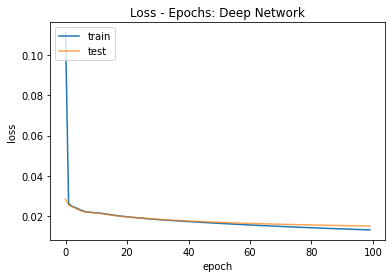

In [ ]:
#Loss - Epochs
plt.figure(figsize = (6, 4))
plt.plot(history_dp.history['loss'], label = 'train')
plt.plot(history_dp.history['val_loss'], alpha = 0.7, label = 'test')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc = 'upper left')
plt.title('Loss - Epochs: Deep Network')

In [ ]:
#Prediction on test dataset
X_test_hat = model_dp_ae.predict(X_test)

In [ ]:
#Convert data into binary data 
X_test_hat_binary = np.where(X_test_hat >= 0.7, 1, 0)

In [ ]:
#Dice Matching Coefficient
# 2 * m_11 / (2 * m_11 + m_10 + m_01)

m_11 = np.sum(np.logical_and(X_test_hat_binary, X_test_binary))
m_10 = np.sum(X_test_binary) - m_11
m_01 = np.sum(X_test_hat_binary) - m_11

2 * m_11 / (2 * m_11 + m_10 + m_01)

0.3389470420891385

In [ ]:
#Precision = TP / (TP + FP)
# Percentage of recommended items that are relevant to user
m_11 / (m_11 + m_01)

0.7794715873348711

In [ ]:
#Recall = TP / (TP + FN)
# Percentage of items of interest to the user that are recommended
m_11 / (m_11 + m_10)

0.21655772658953476

### Recommendation System based on Auto-encoders

In [ ]:
my_rating = np.zeros((1, X_train.shape[1]))

In [ ]:
#Some of my favorite movies:
#2::Jumanji (1995)::Adventure|Children's|Fantasy
#47::Seven (Se7en) (1995)::Crime|Thriller
#260::Star Wars: Episode IV - A New Hope (1977)::Action|Adventure|Fantasy|Sci-Fi
#586::Home Alone (1990)::Children's|Comedy
#1210::Star Wars: Episode VI - Return of the Jedi (1983)::Action|Adventure|Romance|Sci-Fi|War
#1246::Dead Poets Society (1989)::Drama
#1625::Game, The (1997)::Mystery|Thriller
#1707::Home Alone 3 (1997)::Children's|Comedy
#2278::Ronin (1998)::Action|Crime|Thriller
#2986::Robocop 2 (1990)::Action|Crime|Sci-Fi
#3147::Green Mile, The (1999)::Drama|Thriller
#3578::Gladiator (2000)::Action|Drama

my_favorites = np.where((movies_indx == 1) | (movies_indx == 46) | (movies_indx == 259) |
                        (movies_indx == 585) | (movies_indx == 1209) | (movies_indx == 1245) |
                        (movies_indx == 1624) | (movies_indx == 1706) | (movies_indx == 2277) |
                        (movies_indx == 2985) | (movies_indx == 3146) | (movies_indx == 3577))[0]
my_favorites

array([   1,   44,  211,  494,  896,  930, 1217, 1280, 1709, 2291, 2421,
       2741], dtype=int64)

In [ ]:
my_rating[:, my_favorites] = 1
my_rating

array([[0., 1., 0., ..., 0., 0., 0.]])

In [ ]:
my_rating.shape

(1, 3043)

In [ ]:
recommendation = model_b_ae.predict(my_rating)

In [ ]:
recommendation.shape

(1, 3043)

In [ ]:
recommendation

array([[0.01600298, 0.03163001, 0.00502649, ..., 0.00031778, 0.00174829,
        0.00531515]], dtype=float32)

In [ ]:
#intro to argsort
a = np.array([5, 8, 9, 10, 1, 23, 10, 7, 3, 10, 15])

In [ ]:
np.argsort(a)

array([ 4,  8,  0,  7,  1,  2,  3,  6,  9, 10,  5], dtype=int64)

In [ ]:
a[np.argsort(a)]

array([ 1,  3,  5,  7,  8,  9, 10, 10, 10, 15, 23])

In [ ]:
a[np.argsort(a)][-5 : ]

array([10, 10, 10, 15, 23])

In [ ]:
#Indices of first 25 recommended movies
ix = np.argsort(recommendation[0])[-25 : ]

In [ ]:
ix.shape

(25,)

In [ ]:
for i in ix:
    print(movies.loc[movies['movie_id'] == movies_indx[i] + 1, 'title'].values[0])

Jumanji (1995)
Magnolia (1999)
After Life (1998)
Chamber, The (1996)
Rules of Engagement (2000)
Star Wars: Episode I - The Phantom Menace (1999)
Thomas Crown Affair, The (1968)
NeverEnding Story, The (1984)
Jesus' Son (1999)
Talented Mr. Ripley, The (1999)
Ghost Dog: The Way of the Samurai (1999)
Professional, The (a.k.a. Leon: The Professional) (1994)
Sling Blade (1996)
Toy Story 2 (1999)
Home Alone (1990)
Robocop 2 (1990)
Godfather, The (1972)
Ronin (1998)
Game, The (1997)
Dead Poets Society (1989)
Gladiator (2000)
Seven (Se7en) (1995)
Star Wars: Episode IV - A New Hope (1977)
Green Mile, The (1999)
Star Wars: Episode VI - Return of the Jedi (1983)
